# CEE 690, Lecture 23 Code Examples

This course will make use of notebook style coding.  Notebooks are incredibly useful tools both for teaching and for disseminating data anlysis.

This is a set of codes to visit time series and frequency decompositions, and time series statistical models

## Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

This section provides some initialization commands, which can simply be copied for assignments.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# We need to import key libraries that we're going to use.  
# For now this is just numpy, which is our linear algebra library
import numpy as np

Setting the random seed for code reproducibility.

In [2]:
# to make this notebook's output stable across runs, we are going to see the random seed
np.random.seed(42)

Note that we have to reset the random seed _every_ time we run an algorithm if we want the same results!

We also want to set up a plotting environment and make it look pretty.  For those of you familiar with matlab, we will be using matplotlib which is fairly close in syntax and feel.  It's not too far off from R either.

In [3]:
# To plot pretty figures
import matplotlib.pyplot as plt
%matplotlib inline 
# This command figures show up in the notebook.  It's a "magic" command...
# Typically, this now happens by default so it is often an unnecessary command, but is good for standardization.
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

These commands will help us save figures; not going to go through them so much.

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "23"

In [5]:
# makes the directory if it doesn't exist.
import os
if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory didn\'t exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.') 

Figure directory exists.


In [6]:
# a simple defined helper function.
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf',transparent=True)

## Play with CO2 data:


Let's look at atmospheric CO2 concentrations.  In particular, there is a famous dataset from Mauna Loa: https://www.esrl.noaa.gov/gmd/ccgg/trends/full.html

In [7]:
import pandas as pd
co2_df=pd.read_csv('./data/co2_weekly_mlo.txt',header=48,delim_whitespace=True)
co2_df[:5]

,yr,mon,day,decimal,ppm,"#days,",1_yr_ago,10_yr_ago,since_1800
0,1974,5,19,1974.3795,333.34,6,-999.99,-999.99,50.36
1,1974,5,26,1974.3986,332.95,6,-999.99,-999.99,50.06
2,1974,6,2,1974.4178,332.32,5,-999.99,-999.99,49.57
3,1974,6,9,1974.4370,332.18,7,-999.99,-999.99,49.63
4,1974,6,16,1974.4562,332.37,7,-999.99,-999.99,50.07


In [8]:
# some quick_data_cleaning
# replace missing numbers with NaNs for clarity
missing=co2_df['ppm']<0
co2_df['ppm'].values[missing]=np.NaN

In [9]:
times=co2_df['decimal']
co2=co2_df['ppm']

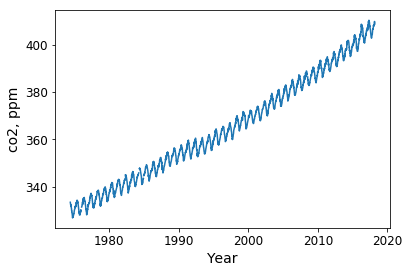

In [10]:
fig=plt.figure()
plt.plot(times,co2)
plt.xlabel('Year')
plt.ylabel('co2, ppm')
plt.show()
savepdf(fig,'c02')

We have some missing data.  We need to fill it in to help this happen, which we will be doing with a spline.  The lectures will come back to this.

In [11]:
from scipy.interpolate import interp1d
not_observed=np.isnan(co2)
interpolator=interp1d(times[~not_observed],co2[~not_observed],kind='cubic')
co2_interpolated=interpolator(times)

### Removing Periodic Trends

As a quick aside, we can try to remove a periodic trend if dates example match.  We'll interpolate to match these exactly.

In [12]:
new_times=np.arange(1975,2018,1/52)
x=interpolator(new_times)

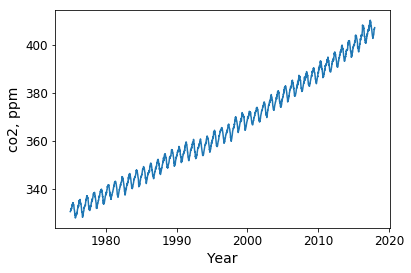

In [13]:
fig=plt.figure()
plt.plot(new_times,x)
plt.xlabel('Year')
plt.ylabel('co2, ppm')
plt.show()
savepdf(fig,'c02_regridded')

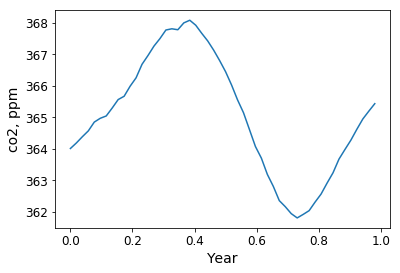

In [14]:
x_by_year=np.reshape(x,[-1,52])
yearly_avg=np.mean(x_by_year,axis=0)
fig=plt.figure()
plt.plot(np.arange(0,1,1/52),yearly_avg)
plt.xlabel('Year')
plt.ylabel('co2, ppm')
savepdf(fig,'yearly_c02_regridded')

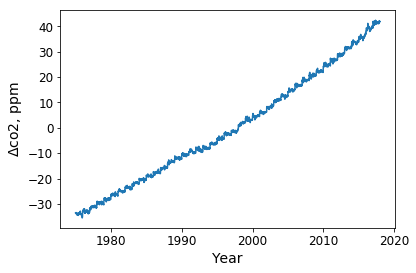

In [15]:
x_deseasoned=x-np.dot(np.ones([x_by_year.shape[0],1]),yearly_avg.reshape([1,52])).reshape(-1)
fig=plt.figure()
plt.plot(new_times,x_deseasoned)
plt.xlabel('Year')
plt.ylabel('$\Delta$co2, ppm')
plt.show()
savepdf(fig,'c02_season_regridded')

### Frequency Decompositions

Let's try a frequency decomposition

In [16]:
co2_fft=np.fft.fft(co2_interpolated)
freqs = np.fft.fftfreq(co2_interpolated.size, times[1]-times[0])

Let's try plotting this to see what it gives

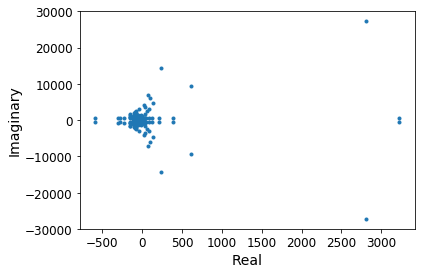

In [17]:
fig=plt.figure()
plt.plot(np.real(co2_fft[1:]),np.imag(co2_fft[1:]),'.')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()
savepdf(fig,'c02_fft')

It's hard to interpret the real and imaginary space...

Let's plot the ### power spectral density instead.

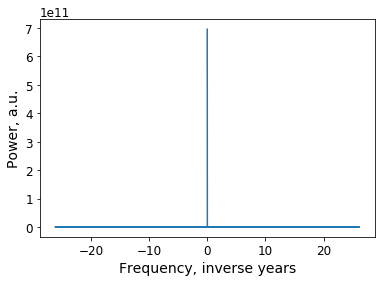

In [18]:
fig=plt.figure()
plt.plot(freqs,np.abs(co2_fft)**2)
plt.xlabel('Frequency, inverse years')
plt.ylabel('Power, a.u.')
plt.show()
savepdf(fig,'c02_psd')

It can be very hard to observe in the original domain.  Instead, let's look at this on the log scale.

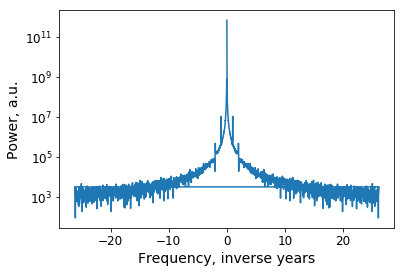

In [19]:
# problem 1 (a)
fig=plt.figure()
plt.semilogy(freqs,np.abs(co2_fft)**2)
plt.xlabel('Frequency, inverse years')
plt.ylabel('Power, a.u.')
plt.show()
savepdf(fig,'c02_psd_log')

Let's restrict this to a power region of greated interest

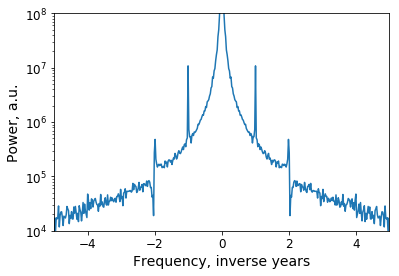

In [20]:
fig=plt.figure()
plt.semilogy(freqs,np.abs(co2_fft)**2,'-')
plt.xlabel('Frequency, inverse years')
plt.ylabel('Power, a.u.')
plt.xlim([-5,5])
plt.ylim([1e4,1e8])
plt.show()
savepdf(fig,'c02_psd_log_limited')

Note that there are both one year and two year periodicities in the data.

Is there actually a half-year cycle?

...

Maybe!

However, in my opinion it's more likely that this is a _harmonic_.  (Wikipedia's not a great research reference, but... https://en.wikipedia.org/wiki/Harmonic is pretty clear).

Nonlinearities (or non-sinusoidal periodicities) cause harmonics to arise in the data.

As a side note, directly using the fft leads to pretty noisy estimates.  There are methods that address the statistically address the noise and are asymptotically consistent, and are built in to most packages.

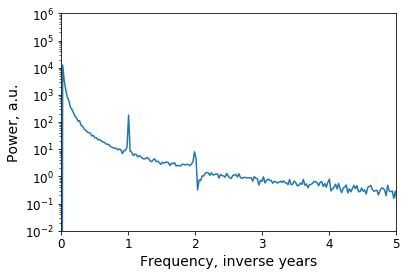

In [21]:
from scipy import signal
fig=plt.figure()
sampling_rate = 1/(times[1]-times[0])
freqs_periodogram,co2_periodogram=signal.periodogram(co2_interpolated,fs=sampling_rate)
plt.semilogy(freqs_periodogram,np.abs(co2_periodogram),'-')
plt.xlabel('Frequency, inverse years')
plt.ylabel('Power, a.u.')
plt.xlim([0,5])
plt.ylim([1e-2,1e6])
plt.show()
savepdf(fig,'c02_psd_log_limited_clear')

## Filtering to clean the data
With this data, we are less interested in the periodic trends and more interested in the overall trend in the data.  We can use frequency filters to remove periodicities that we are uninterested in.

In [22]:
from scipy import signal

First, let's look at a lowpass filter (i.e. only low frequencies can get through.

In [23]:
# Filter specifications.
order = 4 # Order
sampling_rate = 1/(times[1]-times[0]) # in times per years
cutoff = .5  # desired cutoff frequency of the filter, inverse years

In [24]:
print('Our sampling rate is {} times yearly.'.format(sampling_rate))

Our sampling rate is 52.35602094246223 times yearly.


Let's design the filter:

In [25]:
# helper function to put things in more understandable units
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

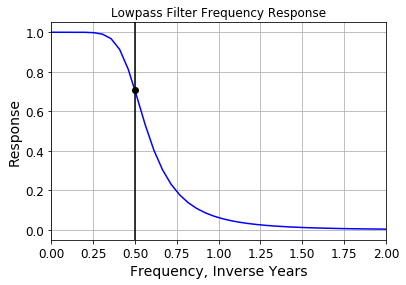

In [26]:
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, sampling_rate, order)
# Plot the frequency response.
w, h = signal.freqz(b, a)
fig=plt.figure()
plt.plot(0.5*sampling_rate*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 2)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency, Inverse Years')
plt.ylabel('Response')
plt.grid()
plt.show()
savepdf(fig,'freq_response')

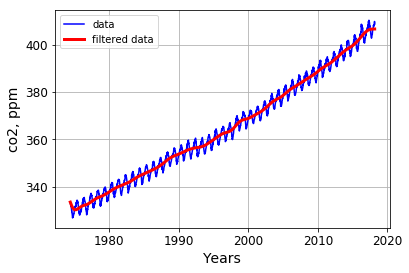

In [27]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

co2_filtered = butter_lowpass_filter(co2_interpolated, cutoff, sampling_rate, order)
fig=plt.figure()
plt.plot(times, co2_interpolated, 'b-', label='data')
plt.plot(times, co2_filtered, 'r-', linewidth=3, label='filtered data')
plt.xlabel('Years')
plt.ylabel('co2, ppm')
plt.grid()
plt.legend()
plt.show()
savepdf(fig,'filtered_data')

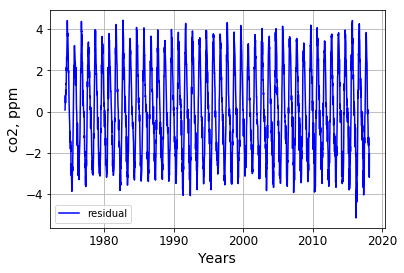

In [28]:
fig=plt.figure()
plt.plot(times, co2_filtered-co2_interpolated, 'b-', label='residual')
plt.xlabel('Years')
plt.ylabel('co2, ppm')
plt.grid()
plt.legend()
plt.show()
savepdf(fig,'filtered_residual')

# Time Frequency Transformations

First, we will explore the "Short-Time Fourier Transform" and use it to draw a spectrogram.

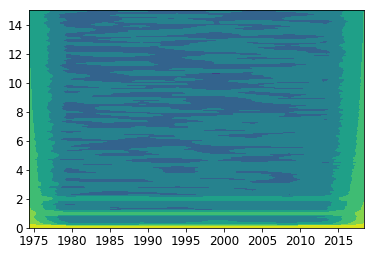

In [29]:
freqs_stft,times_stft,co2_stft=signal.stft(co2_interpolated, fs=sampling_rate,nperseg=512)
plt.contourf(times[0]+times_stft,freqs_stft,np.log(np.abs(co2_stft)))
plt.ylim([0,15])
plt.show()

This dataset isn't so dynamic, so it won't show up well.

Doing the short-time fourier transform can be improved statistically with some nonparametric techniques that I don't have time to explain, but are implemented in the spectrogram call.  Specifically, this is Welch's method.

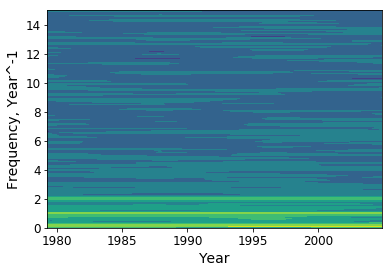

In [30]:
freqs_spec,times_spec,co2_spec=signal.spectrogram(co2_interpolated, fs=sampling_rate,nperseg=512)
fig=plt.figure()
plt.contourf(times[0]+times_spec,freqs_spec,np.log(co2_spec))
plt.ylim([0,15])
plt.xlabel('Year')
plt.ylabel('Frequency, Year^-1')
plt.show()
savepdf(fig,'spec_512')

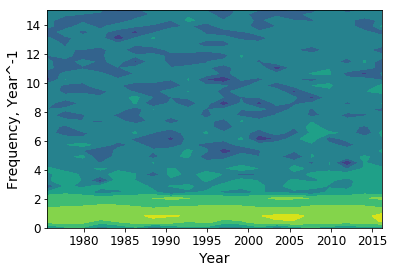

In [31]:
freqs_spec,times_spec,co2_spec=signal.spectrogram(co2_interpolated, fs=sampling_rate,nperseg=128)
fig=plt.figure()
plt.contourf(times[0]+times_spec,freqs_spec,np.log(co2_spec))
plt.ylim([0,15])
plt.xlabel('Year')
plt.ylabel('Frequency, Year^-1')
plt.show()
savepdf(fig,'spec_128')

## Case study on automatic learning of sleep states

There are multiple packages and datasets required to run all of these commands.  These aren't strictly necessary for the class, but are easy to install if desired.

The two packages are `pyedflib` which reads in the so-called "european data format" and the package `hmmlearn` that learns Hidden Markov Models and was originally split off from sklearn.  These can be installed by:  
`pip install pyedflib`  
`pip install hmmlearn`  
The data is available at: https://physionet.nlm.nih.gov/pn4/sleep-edfx/

In [32]:
import pandas as pd
import pyedflib
filename='./data/sleep/SC4001E0-PSG.edf'
try: 
    pyedflib.close_file(filename)
except:
    0;
f = pyedflib.EdfReader(filename)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = [np.zeros((n, f.getNSamples()[0]))]
for i in np.arange(n):
    sigbufs.append(f.readSignal(i))
# We're going to limit outselves to a single channel to start
ch=2
x=sigbufs[ch]
sampling_rate=f.getSampleFrequency(ch)

OSError: can not open file, no such file or directory

In [ ]:
fig=plt.figure()
plt.plot(np.arange(0,len(sigbufs[ch]))/100.,sigbufs[ch])
plt.xlabel('Time, s')
plt.ylabel('Voltage')
plt.show()
savepdf(fig,'full_ts')

Hard to look at the signal all at once, let's consider a smaller section of the signal,

In [ ]:
fig=plt.figure()
plt.plot(np.arange(0,1000)/100.,sigbufs[ch][0:1000])
plt.xlabel('Seconds')
plt.ylabel('Voltage')
plt.show()
savepdf(fig,'partial_ts')

### Let's create a spectrogram 
because it's fun

In [ ]:
from scipy import signal

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

x_filtered=butter_highpass_filter(x,cutoff=4,fs=sampling_rate)

In [ ]:
freqs_perio_or,power_perio_or=signal.periodogram(x,fs=sampling_rate,detrend=None)
fig=plt.figure()
plt.semilogy(freqs_perio_or,np.abs(power_perio_or),'-')
plt.xlabel('Frequency, Hz')
plt.ylabel('Power, a.u.')
plt.ylim([1e-6,1e5])
plt.title('Original Power Spectrum')
plt.show()
savepdf(fig,'psd_orig')

In [ ]:
freqs_perio,power_perio=signal.periodogram(x_filtered,fs=sampling_rate)
fig=plt.figure()
plt.semilogy(freqs_perio,np.abs(power_perio),'-')
plt.xlabel('Frequency, Hz')
plt.ylabel('Power, a.u.')
plt.title('Filtered Power Spectrum')
plt.ylim([1e-12,1e5])
plt.show()
savepdf(fig,'psd_filt')

In [ ]:
fig=plt.figure()
plt.plot(np.arange(0,1000)/100.,x_filtered[0:1000])
plt.xlabel('Seconds')
plt.ylabel('Voltage')
plt.show()
savepdf(fig,'filtered_partial_ts')

In [ ]:
# let's calculate over a 15-second window
freqs,times,power=signal.spectrogram(x, fs=sampling_rate,nperseg=1500)

In [ ]:
power.shape

In [ ]:
power.size

This variable is huge, so we want to reduce the amount we plot.  Frequencies are somewhat redundant for example.

In [ ]:
levels = np.linspace(-8, 7, 40)
fig=plt.figure()
freqs_shown=np.arange(0,power.shape[0],step=5)
times_shown=np.arange(0,power.shape[1],step=10)
plt.contourf(times[times_shown],freqs[freqs_shown],np.log(np.abs(power[freqs_shown][:,times_shown])),levels=levels)
plt.ylim([0,20])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Log-Power')
plt.show()
savepdf(fig,'raw_spectrogram')

In [ ]:
# let's calculate over a 5-second window on filted data
freqs,times,power=signal.spectrogram(x_filtered, fs=sampling_rate,nperseg=500)

In [ ]:
levels = np.linspace(-8, 7, 20)
fig=plt.figure()
freqs_shown=np.arange(0,power.shape[0],step=5)
times_shown=np.arange(0,power.shape[1],step=25)
plt.contourf(times[times_shown],freqs[freqs_shown],np.log(np.abs(power[freqs_shown][:,times_shown])),levels=levels)
plt.ylim([0,20])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Log-Power')
plt.show()
savepdf(fig,'filtered_spectrogram')

Let's lower the dimensionality to make things more computationally tractable

In [ ]:
from sklearn import decomposition

In [ ]:
fa=decomposition.NMF(n_components=5)
S=fa.fit_transform(power.transpose())

In [ ]:
fig=plt.figure()
plt.plot(freqs,fa.components_.transpose())
plt.xlabel('Frequency')
plt.ylabel('P.C.')
plt.xlim([0,20])
plt.title('Power Spectrum of Learned Features')
plt.show()
savepdf(fig,'psd_feats')

In [ ]:
fig=plt.figure()
plt.plot(times,S)
plt.xlabel('Time')
plt.ylabel('Feature Weights')
plt.title('Features through Time')
plt.show()
savepdf(fig,'times_feats')

Visualization of the feature space:

In [ ]:
fig=plt.figure()
plt.scatter(S[:,0],S[:,1])
plt.xlabel('Feature 1, a.u.')
plt.ylabel('Feature 2, a.u.')
plt.show()
savepdf(fig,'emb_feats')

What happens if we cluster the data?

In [ ]:
from sklearn import cluster, mixture

In [ ]:
gmm=mixture.GaussianMixture(n_components=6)
gmm.fit(S)

What is the cluster assignment visualization in the time series?

In [ ]:
fig=plt.figure()
plt.plot(times,gmm.predict(S),'.')
plt.xlabel('Time, s')
plt.ylabel('Cluster Assignment')
plt.yticks(np.arange(0,gmm.n_components))
plt.show()
savepdf(fig,'gmm_clusters')

Note that there is _only a little_ temporal structure in the clustering assignments.

What are the frequency spectrums of each state?

In [ ]:
means=gmm.means_
freq_power=np.dot(means,fa.components_)
fig=plt.figure()
for i in range(0,len(freq_power)):
    plt.plot(freqs,freq_power[i],label=str(i))
plt.legend()
plt.xlim(0,20)
plt.xlabel('Hertz')
plt.ylabel('Power')
plt.title('GMM Cluster Mean PSD')
plt.show()
savepdf(fig,'gmm_feat_psd')

#### Hidden Markov Model

In [ ]:
from hmmlearn import hmm

In [ ]:
model = hmm.GaussianHMM(n_components=6, covariance_type="full",n_iter=50,tol=.0001)
model.fit(S)

In [ ]:
states=model.predict(S)
fig=plt.figure()
plt.plot(states,'.')
plt.xlabel('Time, s')
plt.ylabel('Cluster Assignment')
plt.yticks(np.arange(0,model.n_components))
plt.show()
savepdf(fig,'hmm_clusters')

All of a sudden there is clear temporal structure in the clustering by allowing the markov transition property to be important!

In [ ]:
means=model.means_
freq_power=np.dot(means,fa.components_)
fig=plt.figure()
for i in range(0,len(freq_power)):
    plt.plot(freqs,freq_power[i],label=str(i))
plt.legend()
plt.xlim(0,20)
plt.xlabel('Hertz')
plt.ylabel('Power')
plt.title('HMM Cluster Mean PSD')
plt.show()
savepdf(fig,'hmm_feat_psd')

In [ ]:
means=model.means_
freq_power=np.dot(means,fa.components_)
fig=plt.figure()
fig.add_subplot(121)
for i in range(0,len(freq_power)):
    plt.plot(freqs,freq_power[i],label=str(i))
plt.legend()
plt.xlim([0,15])
plt.xlabel('Hertz')
plt.ylabel('Power')
plt.title('HMM')
means=gmm.means_
freq_power=np.dot(means,fa.components_)
fig.add_subplot(122)
plt.xlim([0,15])
for i in range(0,len(freq_power)):
    plt.plot(freqs,freq_power[i],label=str(i))
plt.legend()
plt.title('GMM')
plt.xlabel('Hertz')
#plt.ylabel('Power')
plt.show()
savepdf(fig,'psd_comp')

What are the transition properties?

In [ ]:
fig=plt.figure()
plt.imshow(model.transmat_)
plt.title('hmm')
plt.xticks(np.arange(0,6))
plt.yticks(np.arange(0,6))
plt.colorbar()
plt.show()
savepdf(fig,'hmm_trans')
#fig.add_subplot(211)
fig=plt.figure()
plt.imshow(gmm.weights_.reshape([1,-1]).repeat(6,axis=0))
plt.title('gmm')
plt.xticks(np.arange(0,6))
plt.yticks(np.arange(0,6))
plt.colorbar()
plt.show()
savepdf(fig,'gmm_trans')

The hidden markov model states that if we're in the current state, we're more likely to stay there.

In [ ]:
print('The probability of self transitions in a hidden markov model are:')
for i in range(0,model.n_components):
    print('state {} has self-transition probability of {}'.format\
          (i,model.transmat_[i,i]))

In [ ]:
print('The probability of self transitions in a gaussian mixture model are:')
for i in range(0,gmm.n_components):
    print('state {} has self-transition probability of {}'.format\
          (i,gmm.weights_[i]))

#### More complex form of a nested model.

In [ ]:
model_complex=hmm.GMMHMM(n_components=6,n_mix=5)
model_complex.fit(S)

In [ ]:
states=model_complex.predict(S)
plt.plot(states,'.')
plt.show()

In [ ]:
#print(model.transmat_)
#fig=plt.figure(0)
fig=plt.figure()
#fig.add_subplot(212)
plt.imshow(model_complex.transmat_,vmin=0,vmax=1)
plt.title('gmm-hmm')
plt.xticks(np.arange(0,6))
plt.yticks(np.arange(0,6))
plt.colorbar()
plt.show()
savepdf(fig,'gmmhmm_trans')
fig=plt.figure()
plt.imshow(model.transmat_,vmin=0,vmax=1)
plt.title('hmm')
plt.xticks(np.arange(0,6))
plt.yticks(np.arange(0,6))
plt.colorbar()
plt.show()
savepdf(fig,'hmm_trans')
#fig.add_subplot(211)
fig=plt.figure()
plt.imshow(gmm.weights_.reshape([1,-1]).repeat(6,axis=0),vmin=0,vmax=1)
plt.title('gmm')
plt.xticks(np.arange(0,6))
plt.yticks(np.arange(0,6))
plt.colorbar()
plt.show()
savepdf(fig,'gmm_trans')